# Natural parameterized quantum circuit for generating superposition states

"Natural parameterized quantum circuit" by T. Haug, M.S. Kim

The Natural parameterized quantum circuit is a parameterized quantum circuit which has euclidean quantum geometry. That means that the quantum Fisher information metric is the identity for a particular parameter set, which we call the reference parameter. This NPQC is very useful for various applications.
- Training variational quantum algorithms
- Multi-parameter quantum sensing
- Preparation of superposition states

We prepare superposition states with the NPQC. The superposition state is composed of a reference state and a target state. We can control the amplitudes of the resulting superposition state by an analytical formula. No training is involved in creating the superposition state!

The implementation is based on qutip

@author: Tobias Haug, github txhaug
Imperial College London


In [1]:
import qutip as qt

from functools import partial

import operator
from functools import reduce
import numpy as np

import scipy
import matplotlib.pyplot as plt

Set parameters for NPQC here

In [2]:

n_qubits=6 #number qubits
depth=6 #number of layers, is the number of layers of parameterized single qubit rotations

type_circuit=0##0: natural parameterized quantum circuit (NPQC), 1: natural parameterized quantum circuit with y rotations only for sensing

initial_angles=1 ##0: random angles 1: reference parameters \theta_r that has QFIM =I

target_state_initial_infidelity=0.1 #infidelity of target state relative to reference state
    
fidelity_superpositon_reference=0.5#fidelity of superposition state and reference state we want to have
fidelity_superpositon_target=0.5 #fidelity of superposition state and target state we want to have

    
random_seed=1#seed of random generator



In [3]:
def prod(factors):
    return reduce(operator.mul, factors, 1)


def flatten(l):
    return [item for sublist in l for item in sublist]

#tensors operators together 
def genFockOp(op,position,size,levels=2,opdim=0):
    opList=[qt.qeye(levels) for x in range(size-opdim)]
    opList[position]=op
    return qt.tensor(opList)

#construct from parameter 1D list a 2D array with [depth,n_qubits], ignore unused rotations where paulis2d=0
def construct_2d_parameters(angles,paulis2d,extraangles=0):
    depth,n_qubits=np.shape(paulis2d)
    angles2d=np.zeros([depth,n_qubits])
    counter=0
    for i in range(depth):
        for j in range(n_qubits):
            if(paulis2d[i,j]>0):
                angles2d[i,j]=angles[counter]
                counter+=1
    if(extraangles==0):
        return angles2d
    else:
        return angles2d,angles[counter:]

#take parameters as a 2D array with [depth,n_qubits] to do 1D list, ignore unused rotations where paulis2d=0
def construct_1d_parameters(angles2d,paulis2d):
    depth,n_qubits=np.shape(paulis2d)
    angles1d=[]
    for i in range(depth):
        for j in range(n_qubits):
            if(paulis2d[i,j]>0):
                angles1d.append(angles2d[i,j])
    
    return np.array(angles1d)


In [4]:
if(n_qubits%2==1):
    raise NameError("Only even number of qubits allowed")


#random generator used
rng = np.random.default_rng(random_seed)

#define angles for circuit
ini_angles=np.zeros([depth,n_qubits])
if(initial_angles==0):
    ini_angles=rng.random([depth,n_qubits])*2*np.pi
elif(initial_angles==1): #choose angles as \theta_r as defined in paper
    ini_angles[1:depth:2,:]=0
    ini_angles[0:depth:2,:]=np.pi/2
    #note that not all angles are actually used, the ones where ini_pauli=0 are ignored


#define rotations for circuit in each layer, 0: identity, 1: X, 2:Y 3:Z
ini_pauli=np.zeros([depth,n_qubits],dtype=int)

##set initial layer of pauli rotations
if(type_circuit==0):#NPQC
    #set first and second layer, rest comes later
    ini_pauli[0,:]=2 #y rotation
    if(depth>1):
        ini_pauli[1,:]=3 #z rotation
        
elif(type_circuit==1): #NPQC with y rotations only for sensing
    #set first and second layer, rest comes later
    ini_pauli[0,0:n_qubits:2]=2 #y rotation
    ini_pauli[0,1:n_qubits:2]=-22 #fix y pi/2 rotation on odd qubit index

        
##define entangling layers and add more pauli rotations
if(type_circuit==0 or type_circuit==1):   
    #construct natural parameterized circuit
    entangling_gate_index_list=[[] for i in range(depth)] ##stores where entangling gates are placed
    orderList=[]
    for i in range(n_qubits//2):
        if(i%2==0):
            orderList.append(i//2)
        else:
            orderList.append((n_qubits-i)//2)

    if(n_qubits>1):
        shiftList=[orderList[0]]
    else:
        shiftList=[]
    for i in range(1,n_qubits//2):
        shiftList.append(orderList[i])
        shiftList+=shiftList[:-1]

    #this list gives which entangling gates are applied in which layer
    for j in range(min(len(shiftList),int(np.ceil(depth/2))-1)):
        entangling_gate_index_list[1+2*j]=[[2*i,(2*i+1+2*shiftList[j])%n_qubits,3] for i in range(n_qubits//2)]

    #this is the 2 qubit entangling operation, it is a pi/2 y rotation on first qubit with CPHASE gate
    U_entangling=qt.qip.operations.csign(2,0,1)*qt.tensor(qt.qip.operations.ry(np.pi/2),qt.qeye(2))
    for i in range(len(entangling_gate_index_list)-1):
        if(len(entangling_gate_index_list[i])>0):
            for j in range(len(entangling_gate_index_list[i])):
                ini_pauli[i+1,entangling_gate_index_list[i][j][0]]=2
                if(i+2<depth and type_circuit==0):##add z rotations, but not for sensing NPQC
                    ini_pauli[i+2,entangling_gate_index_list[i][j][0]]=3




#operators for circuit
levels=2#
opZ=[genFockOp(qt.sigmaz(),i,n_qubits,levels) for i in range(n_qubits)]
opX=[genFockOp(qt.sigmax(),i,n_qubits,levels) for i in range(n_qubits)]
opY=[genFockOp(qt.sigmay(),i,n_qubits,levels) for i in range(n_qubits)]
opId=genFockOp(qt.qeye(levels),0,n_qubits)
opZero=opId*0
zero_state=qt.tensor([qt.basis(levels,0) for i in range(n_qubits)])
      
#construct unitaries for entangling layer
all_entangling_layers=[]         
for ind in range(len(entangling_gate_index_list)):
    if(type_circuit==0 or type_circuit==1):  
        entangling_gate_index=entangling_gate_index_list[ind]
        if(len(entangling_gate_index)==0):
            entangling_layer=opId
        else:
            entangling_layer=prod([qt.qip.operations.gate_expand_2toN(U_entangling,n_qubits,j,k) for j,k,n in entangling_gate_index[::-1]])
    
    all_entangling_layers.append(entangling_layer)

#calculate number of parameters
n_parameters=len(construct_1d_parameters(ini_angles,ini_pauli))



##check which paulis at what depth and qubit is identitity or not
parameter_where=np.zeros([n_parameters,2],dtype=int)
counter=0
for i in range(depth):
    for j in range(n_qubits):
        if(ini_pauli[i,j]>0): #count only paulis with entry greater zero, indicating its a parameter
            parameter_where[counter]=[i,j]
            counter+=1
       

#save single qubit rotations unitary with fixed ini_angles. Use them later for the adjoint circuit needed for sensing
save_initial_rot_op=[]
for j in range(depth):
    rot_op=[]
    for k in range(n_qubits):
        angle=ini_angles[j][k]
        type_pauli=ini_pauli[j][k]
        if(type_pauli==1):
            rot_op.append(qt.qip.operations.rx(angle))
        elif(type_pauli==2):
            rot_op.append(qt.qip.operations.ry(angle))
        elif(type_pauli==3):
            rot_op.append(qt.qip.operations.rz(angle))
        elif(type_pauli==0):
            rot_op.append(qt.qeye(2))
        elif(type_pauli==-22): #fixed rotation around y axis
            rot_op.append(qt.qip.operations.ry(np.pi/2))

    save_initial_rot_op.append(qt.tensor(rot_op))


##H=opZ[0]*opZ[1] #local Hamiltonian to calculate energy and gradient from

print("Number of parameters of PQC",n_parameters)

Number of parameters of PQC 24


In [5]:
##calc_mode #0: calc all gradients 1: calc frame potential only 2: calc both, 3: only get gradient
##can apply adjoint unitary with fixed angles  "add_adjoint_unitary" for sensing
def do_calc(input_angles,input_paulis,get_gradients=True,add_adjoint_unitary=False):
    
    initial_state_save=qt.tensor([qt.basis(levels,0) for i in range(n_qubits)])

    #save here quantum state of gradient for qfi
    grad_state_list=[]
    #list of values of gradient
    gradient_list=np.zeros(n_parameters)
    
    save_rot_op=[]
    #save single-qubit rotations here so we can reuse them
    for j in range(depth):
        rot_op=[]
        for k in range(n_qubits):
            angle=input_angles[j][k]
            type_pauli=input_paulis[j][k]
            if(type_pauli==1):
                rot_op.append(qt.qip.operations.rx(angle))
            elif(type_pauli==2):
                rot_op.append(qt.qip.operations.ry(angle))
            elif(type_pauli==3):
                rot_op.append(qt.qip.operations.rz(angle))
            elif(type_pauli==0):
                rot_op.append(qt.qeye(2))
            elif(type_pauli==-22):
                rot_op.append(qt.qip.operations.ry(np.pi/2))
                
        save_rot_op.append(qt.tensor(rot_op))
        

    #p goes from -1 to n_parameters-1. -1 is to calculate quantum state, rest for gradient
    if(get_gradients==True):
        #calculate gradients by doing n_parameters+1 calcuations
        n_p=n_parameters
    else:
        #without gradient, need only one calculation
        n_p=0
        
    for p in range(-1,n_p):
        initial_state=qt.Qobj(initial_state_save)

        for j in range(depth):
            apply_rot_op=save_rot_op[j]
            
            #for p>=0, we are calculating gradients. Here, we need to add derivative of repsective parameter
            if(p!=-1 and j==parameter_where[p][0]):
                which_qubit=parameter_where[p][1]
                type_pauli=input_paulis[j][which_qubit]
                if(type_pauli==1):
                    apply_rot_op=apply_rot_op*(-1j*opX[which_qubit]/2)
                elif(type_pauli==2):
                    apply_rot_op=apply_rot_op*(-1j*opY[which_qubit]/2)
                elif(type_pauli==3):
                    apply_rot_op=apply_rot_op*(-1j*opZ[which_qubit]/2)

            #apply single qubit rotations
            initial_state=apply_rot_op*initial_state


            #apply entangling layer
            initial_state=all_entangling_layers[j]*initial_state


        #after constructing the circuit, apply inverse with parameters fixed to ini_angles  
        if(add_adjoint_unitary==True):#apply inverse of circuit for sensing
            for j in np.arange(depth)[::-1]:
                initial_state=all_entangling_layers[j].dag()*initial_state
                initial_state=save_initial_rot_op[j].dag()*initial_state



         
        if(p==-1):
            #calculate loss
            circuit_state=qt.Qobj(initial_state)#state generated by circuit
            if(loss_hamiltonian==True):
                #loss is hamiltonian
                loss=qt.expect(H,circuit_state)
            else:
                #loss is infidelity with target state H_state
                loss=1-np.abs(circuit_state.overlap(H_state))**2

    
        else:
            #calculate gradient
            grad_state_list.append(qt.Qobj(initial_state))#state with gradient applied for p-th parameter

            if(loss_hamiltonian==True):
                gradient_list[p]=2*np.real(circuit_state.overlap(H*initial_state))
            else:
                gradient_list[p]=2*np.real(circuit_state.overlap(initial_state)-circuit_state.overlap(H_state)*H_state.overlap(initial_state))


    return circuit_state,grad_state_list,loss,gradient_list

In [6]:
#construct state to be learned
loss_hamiltonian=False #loss is inifidelity 1-F

##generate state to be learned
#we shift parameterized quantum circuit from initial parameters by a fixed distance.
#we know approximatly what distance corresponds to what fidelity

#get random normalized parameter vector
random_vector_opt_normed=(2*rng.random(np.shape(ini_pauli))-1)*(ini_pauli>0)
random_vector_opt_normed=construct_1d_parameters(random_vector_opt_normed,ini_pauli)
random_vector_opt_normed=random_vector_opt_normed/np.sqrt(np.sum(np.abs(random_vector_opt_normed)**2))
random_vector_opt_normed=construct_2d_parameters(random_vector_opt_normed,ini_pauli)

#shift by a distance given by Gaussian kernel
if(target_state_initial_infidelity>0 and target_state_initial_infidelity<1):
    factor_rand_vector=np.sqrt(-4*np.log(1-target_state_initial_infidelity))
else:
    raise NameError("invalid input infidelity")
    
#construct parameter of state to be learned
target_angles=ini_angles+random_vector_opt_normed*factor_rand_vector

H_state=zero_state #set so do_calc runs properly
target_state,_,_,_=do_calc(target_angles,ini_pauli,get_gradients=False)
H_state=target_state #this is state we want to learn

In [7]:
#quantum fisher information metric
#calculated as \text{Re}(\braket{\partial_i \psi}{\partial_j \psi}-\braket{\partial_i \psi}{\psi}\braket{\psi}{\partial_j \psi})

##get gradients for quantum state
circuit_state,grad_state_list,energy,gradient_list=do_calc(ini_angles,ini_pauli,get_gradients=True)


#first, calculate elements \braket{\psi}{\partial_j \psi})
single_qfi_elements=np.zeros(n_parameters,dtype=np.complex128)
for p in range(n_parameters):
    #print(circuit_state.overlap(grad_state_list[p]))
    single_qfi_elements[p]=circuit_state.overlap(grad_state_list[p])
            

#calculcate the qfi matrix
qfi_matrix=np.zeros([n_parameters,n_parameters])
for p in range(n_parameters):
    for q in range(p,n_parameters):
        qfi_matrix[p,q]=np.real(grad_state_list[p].overlap(grad_state_list[q])-np.conjugate(single_qfi_elements[p])*single_qfi_elements[q])
    
    
#use fact that qfi matrix is real and hermitian
for p in range(n_parameters):
    for q in range(p+1,n_parameters):  
        qfi_matrix[q,p]=qfi_matrix[p,q]
        
        


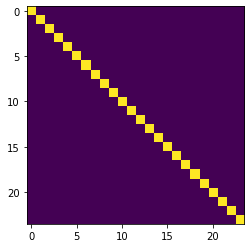

In [8]:
##plot the quantum Fisher information metric (QFIM)
#should be a diagonal with zero off-diagonal entries for initial_angles=1
plt.imshow(qfi_matrix)

Create superposition states with NPQC.
Superposition state is linear combination of reference state and a random target state.
Choose fidelity_superpositon_reference for the fidelity of superposition state with reference state
and choose fidelity_superpositon_target for the fidelity of superposition state with target state.

Then calculates parameters of superposition state with desired fidelities and compares with exact result

In [9]:



##use that fidelity follows an approximate Gaussian kernel to calculate the parameters for the target state
#random_vector_opt_normed=(2*rng.random(np.shape(ini_angles))-1)*(ini_pauli!=0)
#random_vector_opt_normed=random_vector_opt_normed/np.sqrt(np.sum(np.abs(random_vector_opt_normed)**2))
#chosen such that opt_shift_angles corresopnds to change in fidelity for flat quantum geoemtery
#if(target_state_initial_infidelity>0 and target_state_initial_infidelity<1):
#    factor_rand_vector=np.sqrt(-4*np.log(1-target_state_initial_infidelity))
#else:
#    factor_rand_vector=0
#target_angles=ini_angles+random_vector_opt_normed*factor_rand_vector

##parameter of target states - reference state
delta_ref_target_angles=target_angles-ini_angles

##get norm of difference of reference parameter and superposition parameter
#formula is derived in supplemental materials
delta_superposition_angles_norm=np.sqrt(-4*np.log(fidelity_superpositon_reference))#l2 norm

norm_delta_ref_target_angles=np.sqrt(np.sum(np.abs(delta_ref_target_angles)**2))
val_cos=(4*np.log(fidelity_superpositon_target/fidelity_superpositon_reference)+norm_delta_ref_target_angles**2)/(4*norm_delta_ref_target_angles*np.sqrt(-np.log(fidelity_superpositon_reference)))
if(np.abs(val_cos)>=1):
    raise NameError("chosen fidelity_superpositon_reference and fidelity_superpositon_target values do not have a valid solution",val_cos)
    
    

superposition_angles_rel_angle=np.arccos(val_cos)
print("superpositon delta parameter angles norm",delta_superposition_angles_norm,"angle",superposition_angles_rel_angle,"value cos",val_cos)

#get vector orthogonal to delta_ref_target_angles
rand_ortho_vector=(2*rng.random(np.shape(ini_angles))-1)*(ini_pauli!=0)
rand_ortho_vector=np.reshape(rand_ortho_vector,[depth*n_qubits])


reshaped_delta_ref_target_angles=np.reshape(delta_ref_target_angles,[depth*n_qubits])
rand_ortho_vector -= rand_ortho_vector.dot(reshaped_delta_ref_target_angles) * reshaped_delta_ref_target_angles/np.sum(np.abs(reshaped_delta_ref_target_angles)**2)       # make it orthogonal

rand_ortho_vector /= np.linalg.norm(rand_ortho_vector)  # normalize it

#use trigonemtry to calculate how long orthogonal vector must, such that added to delta_ref_target_angles it givec correct angle as calculated for superposition_angles_rel_angle
orth_vector_for_superpos=np.tan(superposition_angles_rel_angle)*norm_delta_ref_target_angles*rand_ortho_vector



#add orth vector and normalize
#IMPORTANT: multiply the ref_target angles with sign of val_cos, to fix whether the superposition angle is in same or opposite direction to ref_target vector
delta_superposition_angles_unit=np.sign(val_cos)*reshaped_delta_ref_target_angles+orth_vector_for_superpos
delta_superposition_angles_unit/=np.linalg.norm(delta_superposition_angles_unit)

#print(val_cos,np.dot(delta_superposition_angles_unit,reshaped_delta_ref_target_angles)/norm_delta_ref_target_angles)

delta_superposition_angles_unit=np.reshape(delta_superposition_angles_unit,[depth,n_qubits])

#rescale vector with correct norm
delta_superposition_angles=delta_superposition_angles_norm*delta_superposition_angles_unit

#get angles for superposition state
superposition_angles=ini_angles+delta_superposition_angles


#we need to calculate our measure as |fidelity superosition state with initial state - fidelity_superpositon_reference|+|fidelity superosition state with target state - fidelity_superpositon_target|
##getting all the fidelities
print("Norm ref target",norm_delta_ref_target_angles,"norm ref superposition",delta_superposition_angles_norm)

#get target state
##H=opZero#set so do_calc runs properly
H_state=zero_state #set so do_calc runs properly
target_state,_,energy,_=do_calc(target_angles,ini_pauli,get_gradients=False)



#get superposition state
superposition_state,_,energy,_=do_calc(superposition_angles,ini_pauli,get_gradients=False)

reference_state,_,energy,_=do_calc(ini_angles,ini_pauli,get_gradients=False)

actual_fidelity_ref_target=np.abs(target_state.overlap(reference_state))**2

actual_fidelity_sup_ref=np.abs(superposition_state.overlap(reference_state))**2
actual_fidelity_sup_target=np.abs(superposition_state.overlap(target_state))**2

##error of superposition state
error_superposition=np.abs(actual_fidelity_sup_ref-fidelity_superpositon_reference)+np.abs(actual_fidelity_sup_target-fidelity_superpositon_target)


print("superposition state error",error_superposition)
print("Fidelity reference and target state",actual_fidelity_ref_target,"(exact",1-target_state_initial_infidelity,")")
print("found fidelity_superpositon_reference",actual_fidelity_sup_ref,"(exact",fidelity_superpositon_reference ,")")
print("found fidelity_superpositon_target",actual_fidelity_sup_target,"(exact",fidelity_superpositon_target ,")")


superpositon delta parameter angles norm 1.6651092223153954 angle 1.3746022217449885 value cos 0.19493787051587097
Norm ref target 0.6491856919490023 norm ref superposition 1.6651092223153954
superposition state error 0.03712273186578219
Fidelity reference and target state 0.9021592093771686 (exact 0.9 )
found fidelity_superpositon_reference 0.5127418934526301 (exact 0.5 )
found fidelity_superpositon_target 0.5243808384131521 (exact 0.5 )
